import all needed packages

In [ ]:
import rdata
import numpy as np
import pandas as pd
#import os, json # os for finding and defining systempaths
import matplotlib.pyplot as plt 
import warnings
import scipy.stats as st
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None 

import needed files with all r peaks

In [ ]:
pre_allinc = rdata.read_rda("0303_INCASI/_dataframes/main_exg2_peaks_s_list.RData")
allinc = pre_allinc["main_exg2_peaks_s_list"]

fin_sys_dur = rdata.read_rda("0303_INCASI/_dataframes/fin_sys_dur_s.RData")
r_tend = pd.DataFrame.from_dict(fin_sys_dur)

log_enc = rdata.read_rda("0303_INCASI/_dataframes/log_encode.RData")
log_enc = log_enc["log_encode"]

data_bins = rdata.read_rda("0303_INCASI/_dataframes/data_bins.RData")
data_bins = data_bins["data_bins"]


define needed variables and empty dataframes

In [ ]:
needed_rows = 0
count = 0
allclicks = pd.DataFrame()
cardiac = pd.DataFrame()
allincs = pd.DataFrame()
rtend_df = pd.DataFrame()

loop that goes through every participant with each r peaks and clicks to sort the clicks into bins (binary) and find relative onset (circular)

In [ ]:
for key, values in allinc.items():

    singleinc = pd.DataFrame(values, columns=["r_peaks"]) 
   
    # calculate ibi for person
    ibi = singleinc["r_peaks"].diff() 
    ibi = ibi.shift(-1)
    singleinc["ibi"] = ibi
    
    # import r-tend intervall for each participant  
    rtend = r_tend["sys_dur_s"].iloc[count] 
    qonR = log_enc["qonR"].iloc[needed_rows]
    peplength = log_enc["pep"].iloc[needed_rows]
    crop = data_bins[data_bins.vp == key].crop.values
    qt = qonR + rtend # get complete length of systole from q to t wave 
    singleinc["qwave"] = singleinc["r_peaks"] - qonR
    ep = float(qt - peplength)
    singleinc["sys_end"] = singleinc.r_peaks + rtend
    # import file with clicks for each loop
    click = pd.DataFrame(log_enc["click1onset_ecgtime_s"][needed_rows: needed_rows +120])
    click.columns = ["clicks"]
  
    needed_rows = needed_rows + 120

    #create bins
    pep = []
    sys = []
    xtime = []
    dias = []

    # loop through clicks and sort them into bins (binary)
    for index, row in singleinc.iterrows():
        q = row["qwave"]
        r = row["r_peaks"]
        tend = row["sys_end"]
        xlen = 0.05
        next_q = singleinc.loc[index + 1, "qwave"] if index + 1 < len(singleinc) else float("inf") # infinitive
        
        pepclick = click.loc[(click["clicks"] >= q) & (click["clicks"] <= (q + peplength))]
        syst = click.loc[(click["clicks"] > (q + peplength)) & (click["clicks"] <= tend)] # sorts into systole if click between r peak and systole-end (twave end)
        xperiod = click.loc[(click["clicks"] > tend) & (click["clicks"] <= (tend + xlen))]
        diast = click.loc[(click["clicks"] > (tend + xlen)) & (click["clicks"] < next_q)] # sorts into diastole if click between systole end and next r peak
        pep.extend(pepclick["clicks"].tolist()) # appending binned values to list 
        sys.extend(syst["clicks"].tolist()) # appending binned values to list 
        xtime.extend(xperiod["clicks"].tolist()) # appending binned values to list 
        dias.extend(diast["clicks"].tolist())   

    pep_df = pd.DataFrame({"clicks": pep}) 
    sys_df = pd.DataFrame({"clicks": sys}) 
    x_df = pd.DataFrame({"clicks": xtime}) 
    dias_df = pd.DataFrame({"clicks": dias})
    pep_clicks = len(pep_df)
    sys_clicks =len(sys_df)
    x_clicks = len(x_df)
    dias_clicks = len(dias_df)

    # circular transformation
    for index, row in click.iterrows():
        diff = row["clicks"] - singleinc.r_peaks 
        diff = diff [diff > 0]
        clos_r_idx = diff.idxmin()
        click.loc[index, "clos_r"] = singleinc.r_peaks[clos_r_idx]
        click.loc[index, "clos_ibi"] = singleinc.ibi[clos_r_idx]
        click.loc[index, "rel"] = diff[clos_r_idx]

    click_circ =[]
    for index, row in click.iterrows():
        res = row["rel"] * 2 * np.pi  * (1 / row["clos_ibi"]) 
        click_circ.append(res)
    click["circ"] = click_circ
    
    # define ratios of clicks in phases of the cardiac cycle to take different phase lengths into account (other cardiac phases are not important here)
    rr = click.clos_ibi.mean()
    diaslength = rr - qt - 0.050
    sysrel = (sys_clicks / 120) / (ep / rr) # syspat is length of sys
    diasrel = (dias_clicks / 120) / ( diaslength / rr) # if rel > 1 higher probability to click during this phase
    
    # calculate circular mean for each participant
    circ_mean = st.circmean(click_circ)
    if circ_mean < 0:
        circ_mean = circ_mean + 2 * np.pi

    # append values to dataframes
    magn = np.sqrt((np.square(np.sum(np.sin(click_circ)))) + (np.square(np.sum(np.cos(click_circ)))))
    temp = pd.DataFrame({"inc": key, "sys": sys_clicks, "dias": dias_clicks, "ibi": rr, "pep": pep_clicks, "x": x_clicks, "sysrel": sysrel, "diasrel": diasrel, "pep_len": peplength, "crop_len": crop, "dias_len": diaslength, "qonR" : qonR, "circ_mean": circ_mean, "magnitude": magn})
    allclicks = pd.concat([allclicks, temp], ignore_index = True)
    singleinc["inc"] = key
    click["inc"] = key
    
    rtend_new = pd.DataFrame({'inc': [key], 'sys_dur': [rtend]})
    rtend_df = pd.concat([rtend_df, rtend_new])
    allincs = pd.concat([allincs, click], ignore_index = True)
    cardiac = pd.concat([cardiac, singleinc], ignore_index = True)
    count = count + 1


In [ ]:
cardiac.to_csv("data/cardiac.csv", index = False)
allincs.to_csv("data/allincs.csv", index = False)
rtend_df.to_csv("data/rtend.csv", index = False)
allclicks.to_csv("data/allclicks.csv", index = False)

# Statistical Testing 


load csv files 

In [ ]:
allclicks = pd.read_csv("data/allclicks.csv")
allincs = pd.read_csv("data/allincs.csv")
cardiac = pd.read_csv("data/cardiac.csv")
r_tend = pd.read_csv("data/rtend.csv")

input of participants you want to look at (if none are inserted the analysis looks at all participants) <br>
participant inc11, inc40, inc41 are excluded because of high bloodpressure and a high heartrate

In [ ]:
included = [] 
excluded = [11, 40, 41] 

filtering out the data for the chosen participants

In [ ]:
if included:
    included = [f"inc{p:02}" for p in included]
if excluded:
    excluded = [f"inc{p:02}" for p in excluded]

if included:
    spec_incs = allincs[allincs["inc"].isin(included)]
    spec_cardiac = cardiac[cardiac["inc"].isin(included)]
    spec_clicks = allclicks[allclicks["inc"].isin(included)]
    spec_rtend = r_tend[r_tend["inc"].isin(included)]

elif excluded:
    spec_incs = allincs[~allincs["inc"].isin(excluded)]
    spec_cardiac = cardiac[~cardiac["inc"].isin(excluded)]    
    spec_clicks = allclicks[~allclicks["inc"].isin(excluded)]
    spec_rtend = r_tend[~r_tend["inc"].isin(excluded)]

else:
    spec_incs = allincs
    spec_cardiac = cardiac
    spec_clicks = allclicks
    spec_rtend = rtend

testing mean of systolic and diastolic rations as well as their standard derivation

In [ ]:
print("mean of all systolic ratios: ", "\t", spec_clicks["sysrel"].mean())
print("mean of all diastolic ratios: ","\t", spec_clicks["diasrel"].mean())
print("standard-derivation of all systolic ratios: ", "\t", np.std(spec_clicks["sysrel"]))
print("standard-derivation of all diastolic ratios: ","\t", np.std(spec_clicks["diasrel"]))
print("standard error of systolic ratio: ", "\t", st.sem(spec_clicks.sysrel))
print("standard error of diastolic ratio: ", "\t", st.sem(spec_clicks.diasrel))

mean of all systolic ratios:  	 1.054931288468781
mean of all diastolic ratios:  	 0.9714682801309014
standard-derivation of all systolic ratios:  	 0.13894318397832348
standard-derivation of all diastolic ratios:  	 0.08042147044926647
standard error of systolic ratio:  	 0.021439398742254565
standard error of diastolic ratio:  	 0.012409302299199197


testing correlations between systolic and diastolic ratio

In [ ]:
print(st.ttest_rel(spec_clicks.sysrel, spec_clicks.diasrel))
print(st.wilcoxon(spec_clicks.sysrel, spec_clicks.diasrel))

def cohens (x,y):
    mean_diff = np.mean(x-y)
    pooled_sd = np.std(y-x)
    cohens_d = mean_diff / pooled_sd
    return cohens_d


print("Cohens d: ", "\t", cohens(spec_clicks.sysrel, spec_clicks.diasrel))

TtestResult(statistic=2.7600175322533467, pvalue=0.008529451826475656, df=42)
WilcoxonResult(statistic=263.0, pvalue=0.01040263543995934)
Cohens d:  	 0.42587995118079736


testing if systolic and diastolic ratio are normally distributed

In [ ]:
print(st.shapiro(spec_clicks.sysrel))
print(st.shapiro(spec_clicks.diasrel))

ShapiroResult(statistic=0.9817510648822774, pvalue=0.7164323077076338)
ShapiroResult(statistic=0.9758061429706271, pvalue=0.49052854783646027)


circular mean of all participants

In [ ]:
print("circular mean of all participants circular means: ", "\t", st.circmean(spec_clicks["circ_mean"])/np.pi)
print("standard derivation of all participants circular means: ", "\t", st.circstd(spec_clicks["circ_mean"])/np.pi)   

circular mean of all participants circular means:  	 0.32821587096665944
standard derivation of all participants circular means:  	 0.5218106853388793


In [ ]:
print(st.shapiro(spec_clicks.circ_mean))

ShapiroResult(statistic=0.9098145417496668, pvalue=0.0025177238652120413)


In [ ]:
print(allclicks.sys.sum())
print(allclicks.dias.sum())

1859
2646


# Plotting Results

### histogram with distribution of systolic and diastolic ratios of all participants

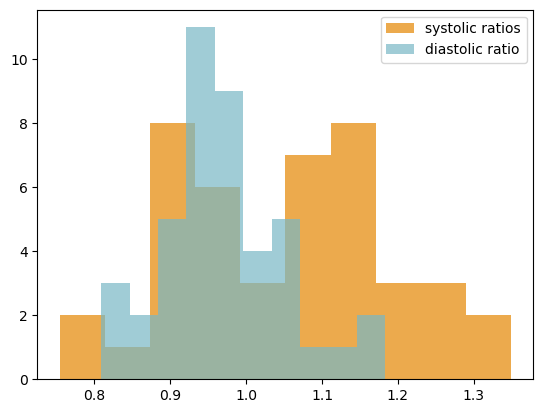

In [ ]:
fig, ax = plt.subplots()
ax.hist(spec_clicks.sysrel, alpha=0.7, label ="systolic ratios", color = "#E58601", bins= 10)
ax.hist(spec_clicks.diasrel, alpha=0.7, label = "diastolic ratio", color = "#78B7C5", bins= 10)
ax.legend(loc="upper right") 
#plt.title("Distribution of Systolic and Diastolic Ratios") 
plt.savefig("plots/histo distribution of ratios 4.png", dpi=350) 
plt.show()

### all clicks from all participants sorted into systole, x-period, diastole, pep

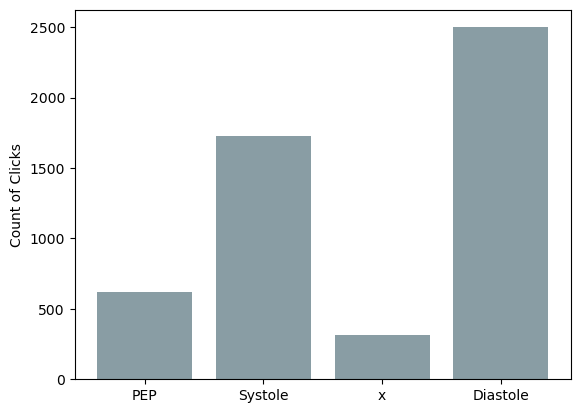

In [ ]:
fig, ax = plt.subplots()
ax.bar(["PEP","Systole", "x", "Diastole"],[spec_clicks.pep.sum(), spec_clicks.sys.sum(), spec_clicks.x.sum(), spec_clicks.dias.sum()], color = "#899DA4")
plt.ylabel("Count of Clicks")
#plt.title("Distribution of 120 Clicks within the Cardiac Cycle")
plt.savefig("plots/distribution of clicks 4.png", dpi=350) 
plt.show()


### binary scatter plot <br>
creating a scatter-plot with one point being one participant with their systolic and diastolic ratio

defining limits for the quadrants

In [ ]:
small_sys = spec_clicks.sysrel < 1
big_sys = spec_clicks.sysrel > 1
small_dias = spec_clicks.diasrel < 1
big_dias = spec_clicks.diasrel > 1
sys_mean = spec_clicks["sysrel"].mean()
dias_mean = spec_clicks["diasrel"].mean()

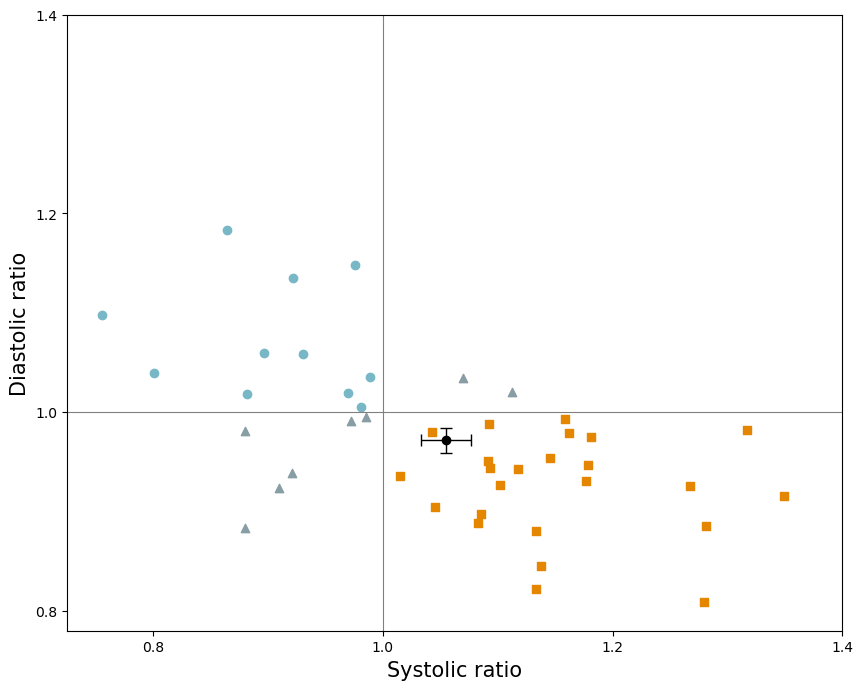

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.axline((1, 0.8), (1, 1.2 ), linewidth = 0.8, color = "gray")
ax.axline((0.8, 1), (1.2, 1), linewidth = 0.8, color = "gray")
ax.scatter(spec_clicks[(small_sys) & (small_dias)].sysrel, spec_clicks[(small_sys) & (small_dias)].diasrel, color="#899DA4", marker="^")
ax.scatter(spec_clicks[(small_sys) & (big_dias)].sysrel, spec_clicks[(small_sys) & (big_dias)].diasrel, color="#78B7C5")
ax.scatter(spec_clicks[(big_sys) & (small_dias)].sysrel, spec_clicks[(big_sys) & (small_dias)].diasrel, color="#E58601",marker= "s")
ax.scatter(spec_clicks[(big_sys) & (big_dias)].sysrel, spec_clicks[(big_sys) & (big_dias)].diasrel, color="#899DA4", marker="^")
plt.errorbar( sys_mean, dias_mean, xerr = st.sem(spec_clicks.sysrel), yerr= st.sem(spec_clicks.diasrel),fmt='o', color = "black", elinewidth=1, capsize=4)
plt.xlabel("Systolic ratio", fontsize=15 )
plt.ylabel("Diastolic ratio", fontsize = 15)
plt.xticks([0.8, 1.0, 1.2, 1.4])
plt.yticks([0.8, 1.0, 1.2, 1.4])
plt.rcParams["figure.figsize"]= [4.5,4.5]
#plt.title("Systolic and Diastolic Ratios of all Participants") 
plt.savefig("plots/binary scatterplot 4.png", dpi=350) 
plt.show()

### single inc circular plot

insert participant chosen first level analysis circular plot showing all 120 clicks and their density

In [ ]:
inc = 25

defining variables adjusted to the chosen inc

In [ ]:
inc = f"inc{inc:02}"
circ_trans = 2 * np.pi * (1/ allclicks[allclicks["inc"] == inc].ibi.iloc[0])
sys_start = allclicks[allclicks["inc"] == inc].crop_len.iloc[0] * circ_trans
sys_end = r_tend[r_tend["inc"] == inc].sys_dur.iloc[0] * circ_trans
dias_start = sys_end + (0.05  * circ_trans)
dias_end = dias_start + (allclicks[allclicks["inc"] == inc].dias_len.iloc[0] * circ_trans)

circ_clicks = allincs[allincs["inc"] == inc].circ.sort_values()
mean = allclicks[allclicks["inc"] == inc].circ_mean.iloc[0]
magn = allclicks[allclicks["inc"] == inc].magnitude.iloc[0]/len(circ_clicks)

In [ ]:
mu = st.circmean(circ_clicks)
sin_sum = np.sum(np.sin(circ_clicks))
cos_sum = np.sum(np.cos(circ_clicks))

two_circ_clicks = pd.concat([circ_clicks[circ_clicks > np.pi] - 2*np.pi, circ_clicks, circ_clicks[circ_clicks < np.pi] + 2*np.pi], ignore_index=True)

kernel = st.gaussian_kde(two_circ_clicks, bw_method=.05)
density= kernel.pdf(two_circ_clicks)
ran = len(two_circ_clicks[two_circ_clicks < 0])

r = np.full_like(np.linspace(0, 2*np.pi, 100), 1 )

plotting the results

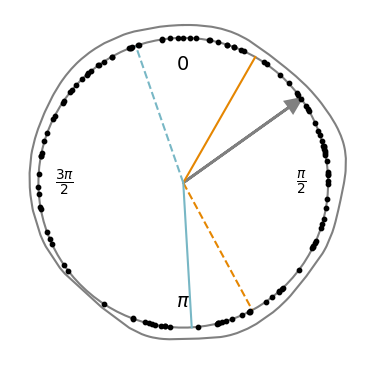

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(np.linspace(0, 2*np.pi, 100), r , color = "gray", label = "Density-Minimum")
ax.plot(two_circ_clicks[ran-1:ran+120], density[ran-1:ran+120] +1, color="gray", label="Von Mises Density")
ax.plot([sys_start,sys_start], [0,1], color = "#E58601", label = "Systole Start" )
ax.plot([sys_end,sys_end], [0,1], color = "#E58601", label = "Systole End", ls = "--")
ax.plot([dias_start,dias_start], [0,1], color = "#78B7C5", label = "Diastole Start" )
ax.plot([dias_end,dias_end], [0,1], color = "#78B7C5", label = "Diastole End", ls = "--" )
ax.scatter(circ_clicks, np.ones(120), s = 10, color = "black", zorder = 2)
ax.arrow(mean, 0, 0, 0.9, color="gray", head_width=0.1, head_length=0.1, lw= 2)
ax.set_theta_direction(-1)  # counterclockwise direction
ax.set_theta_zero_location("N")  # zero angle to north
ax.set_yticklabels([])  # no radial labels
ax.set_yticks([])  # no radial grid lines
ax.set_xticks(np.linspace(0, 2 * np.pi, 5 ))  
ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", ""], fontsize = 14)  # label ticks
ax.spines["polar"].set_visible(False)
ax.tick_params(axis="x", pad=-50) 
ax.grid(False)
#plt.title("Circular Click Distribution " + inc) 
#plt.legend(loc = "upper left")
plt.savefig("plots/circular clicks inc 25.png", dpi=350) 
plt.show()

In [ ]:
print(mean/np.pi)
print(magn)

0.3026261017223828
0.14584204405360682


### circular histogram showing all clicks of all participants over the cardiac cycle

insert number of bins you want for the histogram

In [ ]:
bin_num = 30 

defining needed variables

In [ ]:
data = spec_incs["circ"]
r_tend_mean = spec_rtend.sys_dur.mean() * 2 * np.pi
r_tend_std = spec_rtend.sys_dur.std() * 2 * np.pi
systole = data[data < r_tend_mean]
diastole = data[data > r_tend_mean]
binsize = round(r_tend_mean / (2 * np.pi) * bin_num)

plotting the histogram

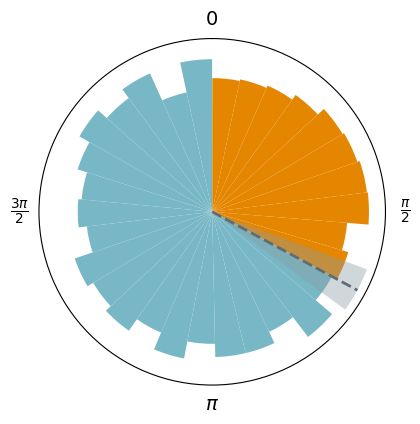

In [ ]:
ax = plt.subplot(projection="polar")
ax.hist(systole, bins=binsize, color="#E58601")
ax.hist(diastole, bins=(bin_num - binsize), color="#78B7C5")
ax.set_theta_direction(-1)  # counterclockwise direction
ax.set_theta_zero_location("N")  # zero angle to north
ax.set_yticklabels([])  # no radial labels
ax.set_yticks([])  # no radial grid lines
ax.set_xticks(np.linspace(0, 2 * np.pi, 5))  
ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", ""], fontsize = 14)  # label ticks
ax.plot([r_tend_mean, r_tend_mean], [0, 200], color="#5f6d72", linestyle="--", linewidth=2, label = "mean of all r-tend-intervalls")  # mean of r t end
ax.bar(x = r_tend_mean, height= 200, width = r_tend_std * 2, color = "#899DA4",alpha = 0.4)
#ax.set_title("Circular Histogramm of Clicks from all Participants")
ax.grid(False)
#plt.legend(loc="lower right")
plt.savefig("plots/circular histo all clicks 4.png", dpi=350) 
plt.show()

In [ ]:
print(r_tend_mean/np.pi)
print(r_tend_std/np.pi)

0.6575899345930233
0.04430297535614479


### circular plot all incs <br>
plot showing the circular mean of each participant as a dot as well as the overall circular density

defining different parts of the cardiac cycle

In [ ]:
circ_means = spec_clicks["circ_mean"].sort_values()

ibi_circ = []
for ibi in spec_clicks["ibi"]:
    ibi_trans = (2 * np.pi) / ibi 
    ibi_circ.append(ibi_trans)
spec_clicks["ibi_circ"] = ibi_circ 

circ_trans_all = np.mean(spec_clicks["ibi_circ"])

crop_circ = []
for crop in spec_clicks["crop_len"]:
    crop_trans = circ_trans_all * crop
    crop_circ.append(crop_trans)
spec_clicks["crop_circ"] = crop_circ 

rt_circ = []
for rt in spec_rtend["sys_dur"]:
    rt_trans = circ_trans_all * rt
    rt_circ.append(rt_trans)
spec_rtend["rt_circ"] = rt_circ 

dias_circ = []
for dias in spec_clicks["dias_len"]:
    dias_trans = circ_trans_all * dias
    dias_circ.append(dias_trans)
spec_clicks["dias_circ"] = dias_circ 

sys_start_all = np.mean(spec_clicks["crop_circ"])
sys_end_all = np.mean(spec_rtend["rt_circ"])
dias_start_all = np.mean(sys_end_all + (0.05 * circ_trans_all))
dias_end_all = np.mean(dias_start_all + dias_circ)

calculating the circular density with the von-mises-distribution

In [ ]:
circ_means = circ_means.sort_values()
sin_sum_spec = np.sum(np.sin(circ_means))
cos_sum_spec = np.sum(np.cos(circ_means))
mu_spec = st.circmean(circ_means)
spec_magn = np.sqrt(np.square(sin_sum_spec) + (np.square(cos_sum_spec))) / len(circ_means)

two_circ_means = pd.concat([circ_means[circ_means > np.pi] - 2*np.pi, circ_means, circ_means[circ_means < np.pi] + 2*np.pi], ignore_index=True)
all_kernel = st.gaussian_kde(two_circ_means, bw_method=.1)
all_density= all_kernel.pdf(two_circ_means)
ran_all = len(two_circ_means[two_circ_means < 0])
r = np.full_like(np.linspace(0, 2*np.pi, 100), 1 )

In [ ]:
nBoot = 100  # default = 10000, switch to 100 if necessary
vplist = list(spec_rtend["inc"])  # unique(log_encode$vp) # list of participants

out = []
buffer = []
bwparam = 0.5 # bandwidth parameter

for i in range(nBoot):  # repeat bootstrap procedure nBoot times
    vplist_boot = np.random.choice(vplist, size=len(vplist), replace=True)  # draw bootstrap sample
    buffer = []
    for j in range(len(vplist_boot)):  # compute circular density for each participant in sample
        x = spec_incs[spec_incs["inc"] == vplist_boot[j]].circ.values
        gauss_kde = st.gaussian_kde(x, bw_method=.1)
        dens= gauss_kde.pdf(x)
        buffer.append(dens)
    buffer = np.array(buffer)  
    mean_dens = np.mean(buffer)
    out.append(mean_dens)

out = np.array(out)

out_1 = []
for num in out:
    out_1.append(num+1)     


In [ ]:
print(out)

[0.17291732 0.17197137 0.17192878 0.17248633 0.17256883 0.17280259
 0.17208423 0.17109236 0.17199682 0.17223424 0.17116811 0.17273212
 0.17140942 0.17063809 0.17032686 0.17162644 0.17137141 0.17228909
 0.17242575 0.17138922 0.17283187 0.17300853 0.1715662  0.17259198
 0.17286058 0.17258035 0.17161558 0.17172167 0.1716417  0.17361618
 0.17177564 0.17247111 0.17081452 0.17303237 0.17248027 0.17221168
 0.17277884 0.17210747 0.17177054 0.1722343  0.17153928 0.17208304
 0.17276502 0.17175361 0.17162303 0.17193266 0.17212834 0.17362749
 0.17274652 0.1712769  0.17122651 0.17204128 0.17166259 0.17172274
 0.17288296 0.17236399 0.17188091 0.17294919 0.17380204 0.17288275
 0.17072114 0.17256551 0.17284746 0.1730484  0.17180222 0.17158353
 0.17215545 0.17159103 0.17205227 0.17276638 0.17279345 0.1715637
 0.17206917 0.17132427 0.17307296 0.17280305 0.17194615 0.17275011
 0.17217245 0.17228319 0.17397647 0.17249453 0.17294986 0.17381281
 0.17205838 0.17323224 0.17251253 0.17344149 0.17163829 0.17251

In [ ]:
ci_upper = []
ci_lower = []
ci_median = []

for i in range(len(out)):
    ci_lower.append(np.quantile(out[:, i], 0.025))  # 2.5% percentile
    ci_upper.append(np.quantile(out[:, i], 0.975))  # 97.5% percentile
    ci_median.append(np.quantile(out[:, i], 0.5))   # median

ci_lower = np.array(ci_lower)
ci_upper = np.array(ci_upper)
ci_median = np.array(ci_median)

# Define the uniform circular density function
def dcircularuniform(x):
    return np.ones_like(x) / (2 * np.pi)

# Find indices where ci_lower is significantly higher than the uniform distribution
markup_upper = np.where(ci_lower > dcircularuniform(1))[0]

# Find indices where ci_upper is significantly lower than the uniform distribution
markup_lower = np.where(ci_upper < dcircularuniform(1))[0]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

plotting clicks and density

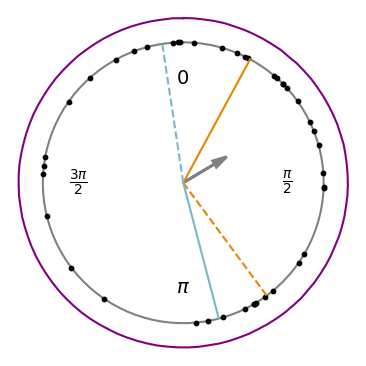

In [ ]:
theta = np.linspace(0, 2 * np.pi, 100)
ax = plt.subplot(projection="polar")
ax.plot(np.linspace(0, 2* np.pi, 100), r , color = "gray", label = "Density-Minimum")
ax.scatter(circ_means, np.ones_like(circ_means), s = 10, color = "black", zorder = 2)
#ax.plot(two_circ_means[ran_all - 1 : ran_all + len(circ_means)], all_density[ran_all - 1 : ran_all + len(circ_means)] +1, color="gray", label="Von Mises Density")
ax.arrow(mu_spec, 0, 0, spec_magn, color="gray", head_width=0.2, head_length=0.1, lw=2)
ax.plot(theta, out_1, color="purple")
ax.plot([sys_start_all,sys_start_all], [0,1], color = "#E58601", label = "Systole Start" )
ax.plot([sys_end_all,sys_end_all], [0,1], color = "#E58601", label = "Systole End", ls = "--")
ax.plot([dias_start_all,dias_start_all], [0,1], color = "#78B7C5", label = "Diastole Start" )
ax.plot([dias_end_all,dias_end_all], [0,1], color = "#78B7C5", label = "Diastole End", ls = "--" )
ax.set_theta_direction(-1)  # counterclockwise direction
ax.set_theta_zero_location("N")  # zero angle to north
ax.set_yticklabels([])  # no radial labels
ax.set_yticks([])  # no radial grid lines
ax.set_xticks(np.linspace(0, 2 * np.pi, 5))  
ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", ""], fontsize = 14)  # label ticks
ax.spines['polar'].set_visible(False)
ax.grid(False)
ax.tick_params(axis="x", pad=-60)  
#ax.set_title("Circular Histogramm of Circular Means of all Participants")
#plt.legend(loc="lower right")
plt.savefig("plots/circ means 4.png", dpi=350) 
plt.show()

In [ ]:
print(mu_spec/np.pi)
print(spec_magn)

0.32821587096665944
0.260883982198851


In [ ]:
print(len(circ_means[circ_means < sys_start_all]))
print(len(circ_means[circ_means < sys_end_all]))
print(len(circ_means[circ_means < dias_start_all]))
print(len(circ_means[circ_means < dias_end_all]))
print(len(circ_means[circ_means < 2*np.pi]))



5
20
27
40
43


In [313]:
import numpy as np
import scipy.stats 
import pandas as pd
import os, json # os for finding and defining systempaths
import matplotlib.pyplot as plt 
import warnings
from math import pi
import scipy.stats as st
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None 

import json file with all r peaks

In [244]:
with open ("/Users/emiliahildebrandt/BBSIG script and data/code_x/rdf_csv/all_inc.json") as peaks_allinc_json:
    rpeaks_allinc = json.load(peaks_allinc_json)
allinc = json.loads(rpeaks_allinc[0])


define needed variables and empty dataframes

In [245]:
needed_rows = 0
allclicks = pd.DataFrame()
cardiac = pd.DataFrame()
allincs = pd.DataFrame()

loop that goes through every participant with each r peaks and clicks to sort the clicks into bins (binary) and find relative onset (circular)

In [246]:

for key, values in allinc.items():
    singleinc = pd.DataFrame(allinc[key])     # import r peaks for current participant 
    singleinc.rename(columns={singleinc.columns[0]: "r_peaks"}, inplace = True) # is it possible to rename somewhere else to make the code shorter?
  
    # calculate ibi for person
    ibi = singleinc["r_peaks"].diff() 
    ibi = ibi.shift(-1)
    singleinc["ibi"] = ibi

    # import r-tend intervall for each participant
    rtend = pd.read_csv("/Users/emiliahildebrandt/BBSIG script and data/code_x/rdf_csv/sysdurs.csv", sep =";", decimal = ",", header = 0, names = ["p", "sys_dur"])
    qonR = pd.read_csv("/Users/emiliahildebrandt/BBSIG script and data/code_x/rdf_csv/log_encode.csv", header= 0, sep = ";", decimal = ",", usecols= [36], names = ["qonR"]).loc[needed_rows, "qonR"]
    peplength = pd.read_csv("/Users/emiliahildebrandt/BBSIG script and data/code_x/rdf_csv/log_encode.csv", header= 0, sep = ";", decimal = ",", usecols= [35]).loc[needed_rows, "pep"]    
    qt = qonR + rtend[rtend.p == key].sys_dur.values # get complete length of systole from q to t wave 
    singleinc["qwave"] = singleinc["r_peaks"] - qonR
    ep = float(qt - peplength)
    singleinc["sys_end"] = singleinc.r_peaks + rtend[rtend.p == key].sys_dur.values
    
    # import file with clicks for each loop
    click = pd.read_csv("/Users/emiliahildebrandt/BBSIG script and data/code_x/rdf_csv/log_encode.csv", header= 0, sep = ";", decimal = ",", usecols= [22], names = ["clicks"])    
    clickinc = click[needed_rows: needed_rows + 120] # only use first 120 clicks aka all clicks from inc 04
    needed_rows = needed_rows + 120

    #create bins
    pep = []
    sys = []
    xtime = []
    dias = []

    # loop through clicks and sort them into bins (binary)
    for index, row in singleinc.iterrows():
        q = row["qwave"]
        r = row["r_peaks"]
        tend = row["sys_end"]
        xlen = 0.05
        next_q = singleinc.loc[index + 1, "qwave"] if index + 1 < len(singleinc) else float("inf") # infinitive
        
        pepclick = clickinc.loc[(clickinc["clicks"] >= q) & (clickinc["clicks"] <= (q + peplength))]
        syst = clickinc.loc[(clickinc["clicks"] > (q + peplength)) & (clickinc["clicks"] <= tend)] # sorts into systole if click between r peak and systole-end (twave end)
        xperiod = clickinc.loc[(clickinc["clicks"] > tend) & (clickinc["clicks"] <= (tend + xlen))]
        diast = clickinc.loc[(clickinc["clicks"] > (tend + xlen)) & (clickinc["clicks"] < next_q)] # sorts into diastole if click between systole end and next r peak
        pep.extend(pepclick["clicks"].tolist()) # appending binned values to list 
        sys.extend(syst["clicks"].tolist()) # appending binned values to list 
        xtime.extend(xperiod["clicks"].tolist()) # appending binned values to list 
        dias.extend(diast["clicks"].tolist())

    pep_df = pd.DataFrame({"clicks": pep}) 
    sys_df = pd.DataFrame({"clicks": sys}) 
    x_df = pd.DataFrame({"clicks": xtime}) 
    dias_df = pd.DataFrame({"clicks": dias})
    pep_clicks = len(pep_df)
    sys_clicks =len(sys_df)
    x_clicks = len(x_df)
    dias_clicks = len(dias_df)

    # circular transformation
    for index, row in clickinc.iterrows():
        diff = row["clicks"] - singleinc.r_peaks 
        diff = diff [diff > 0]
        clos_r_idx = diff.idxmin()
        clickinc.loc[index, "clos_r"] = singleinc.r_peaks[clos_r_idx]
        clickinc.loc[index, "clos_ibi"] = singleinc.ibi[clos_r_idx]
        clickinc.loc[index, "rel"] = diff[clos_r_idx]

    click_circ =[]
    for index, row in clickinc.iterrows():
        res = row["rel"] * 2 * pi  * (1 / row["clos_ibi"])  #how do i find r peak to implement right ibi?
        click_circ.append(res)
    clickinc["circ"] = click_circ
    
    # define ratios of clicks in phases of the cardiac cycle to take different phase lengths into account (other cardiac phases are not important here)
    rr = clickinc.clos_ibi.mean()
    diaslength = rr - qt - 0.050
    sysrel = (sys_clicks / 120) / (ep / rr) # syspat is length of sys
    diasrel = (dias_clicks / 120) / ( diaslength / rr) # if rel > 1 higher probability to click during this phase
    
    # calculate circular mean for each participant
    circ_mean = np.arctan2(np.sum(np.sin(click_circ)), np.sum(np.cos(click_circ)))
    if circ_mean < 0:
        circ_mean = circ_mean + 2 * pi

    # append values to dataframes
    magn = np.sqrt((np.square(np.sum(np.sin(click_circ)))) + (np.square(np.sum(np.cos(click_circ)))))
    temp = pd.DataFrame({"inc": key, "sys": sys_clicks, "dias": dias_clicks, "pep": pep_clicks, "x": x_clicks, "sysrel": sysrel, "diasrel": diasrel, "pep_len": peplength, "qonR" : qonR, "circ_mean": circ_mean, "magnitude": magn})
    allclicks = pd.concat([allclicks, temp], ignore_index = True)
    singleinc["inc"] = key
    clickinc["inc"] = key
    allincs = pd.concat([allincs, clickinc], ignore_index = True)
    cardiac = pd.concat ([cardiac, singleinc], ignore_index = True)

load created dataframes and lists into csv-files

In [247]:

cardiac.to_csv("/Users/emiliahildebrandt/BBSIG script and data/code_x/data/cardiac.csv", index = False)
allincs.to_csv("/Users/emiliahildebrandt/BBSIG script and data/code_x/data/allincs.csv", index = False)
rtend.to_csv("/Users/emiliahildebrandt/BBSIG script and data/code_x/data/rtend.csv", index = False)
allclicks.to_csv("/Users/emiliahildebrandt/BBSIG script and data/code_x/data/allclicks.csv", index = False)


# Statistical Testing 


load csv files 

In [278]:
allclicks = pd.read_csv("/Users/emiliahildebrandt/BBSIG script and data/code_x/data/allclicks.csv")
allincs = pd.read_csv("/Users/emiliahildebrandt/BBSIG script and data/code_x/data/allincs.csv")
cardiac = pd.read_csv("/Users/emiliahildebrandt/BBSIG script and data/code_x/data/cardiac.csv")
r_tend = pd.read_csv("/Users/emiliahildebrandt/BBSIG script and data/code_x/data/rtend.csv")

input of participants you want to look at (if none are inserted the analysis looks at all participants) <br>
participant inc11, inc40, inc41 are excluded because of high bloodpressure and a high heartrate

In [279]:
included = [] 
excluded = [11, 40, 41] 

filtering out the data for the chosen participants

In [280]:
if included:
    included = [f"inc{p:02}" for p in included]
if excluded:
    excluded = [f"inc{p:02}" for p in excluded]

if included:
    spec_incs = allincs[allincs["inc"].isin(included)]
    spec_cardiac = cardiac[cardiac["inc"].isin(included)]
    spec_clicks = allclicks[allclicks["inc"].isin(included)]
    spec_rtend = rtend[rtend["p"].isin(included)]

elif excluded:
    spec_incs = allincs[~allincs["inc"].isin(excluded)]
    spec_cardiac = cardiac[~cardiac["inc"].isin(excluded)]    
    spec_clicks = allclicks[~allclicks["inc"].isin(excluded)]
    spec_rtend = rtend[~rtend["p"].isin(excluded)]

else:
    spec_incs = allincs
    spec_cardiac = cardiac
    spec_clicks = allclicks
    spec_rtend = rtend

testing mean of systolic and diastolic rations as well as their standard derivation

In [253]:
print("mean of all systolic ratios: ", "\t", spec_clicks["sysrel"].mean())
print("mean of all diastolic ratios: ","\t", spec_clicks["diasrel"].mean())
print("standard-derivation of all systolic ratios: ", "\t", spec_clicks["sysrel"].std())
print("standard-derivation of all diastolic ratios: ","\t", spec_clicks["diasrel"].std())


mean of all systolic ratios:  	 1.0446527315785936
mean of all diastolic ratios:  	 0.9826572946451931
standard-derivation of all systolic ratios:  	 0.1445776449937341
standard-derivation of all diastolic ratios:  	 0.08925014379707914


testing correlations between systolic and diastolic ratio

In [254]:
print(st.ttest_rel(spec_clicks.sysrel, spec_clicks.diasrel))
print(st.wilcoxon(spec_clicks.sysrel, spec_clicks.diasrel))

TtestResult(statistic=1.9912634631294381, pvalue=0.05254352960748847, df=45)
WilcoxonResult(statistic=363.0, pvalue=0.052547730973884654)


testing if systolic and diastolic ratio are normally distributed

In [255]:
print(st.shapiro(spec_clicks.sysrel))
print(st.shapiro(spec_clicks.diasrel))

ShapiroResult(statistic=0.9834171914087009, pvalue=0.7474096533419167)
ShapiroResult(statistic=0.9686843901925584, pvalue=0.24737241346423783)


# Plotting Results

### histogram with distribution of systolic and diastolic ratios of all participants

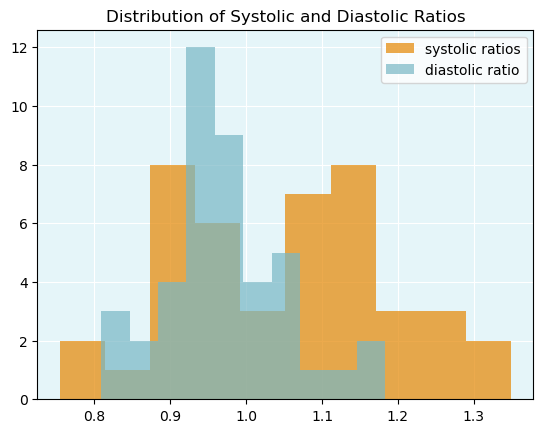

In [289]:
fig, ax = plt.subplots()
ax.hist(spec_clicks.sysrel, alpha=0.7, label ="systolic ratios", color = "#E58601")
ax.hist(spec_clicks.diasrel, alpha=0.7, label = "diastolic ratio", color = "#78B7C5")
ax.legend(loc="upper right") 
plt.title("Distribution of Systolic and Diastolic Ratios") 
ax.set_facecolor("#e5f5f9")
ax.grid(True, color="white")  
ax.set_axisbelow(True) 
plt.savefig("/Users/emiliahildebrandt/BBSIG script and data/code_x/plots/histo distribution of ratios 4.png", dpi=350) 
plt.show()


### all clicks from all participants sorted into systole, x-period, diastole, pep

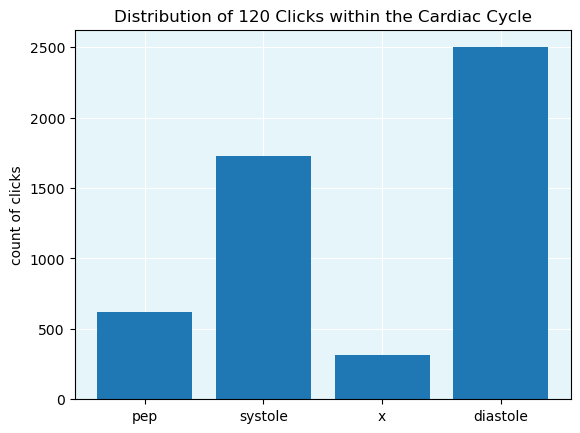

In [86]:
fig, ax = plt.subplots()
ax.bar(["pep","systole", "x", "diastole"],[spec_clicks.pep.sum(), spec_clicks.sys.sum(), spec_clicks.x.sum(), spec_clicks.dias.sum()])
ax.set_facecolor("#e5f5f9")
ax.grid(True, color="white")  
ax.set_axisbelow(True) 
plt.ylabel("count of clicks")
plt.title("Distribution of 120 Clicks within the Cardiac Cycle")
plt.savefig("/Users/emiliahildebrandt/BBSIG script and data/code_x/plots/distribution of clicks 4.png", dpi=350) 
plt.show()


### binary scatter plot <br>
creating a scatter-plot with one point being one participant with their systolic and diastolic ratio

defining limits for the quadrants

In [316]:
small_sys = spec_clicks.sysrel < 1
big_sys = spec_clicks.sysrel > 1
small_dias = spec_clicks.diasrel < 1
big_dias = spec_clicks.diasrel > 1
sys_mean = spec_clicks["sysrel"].mean()
dias_mean = spec_clicks["diasrel"].mean()

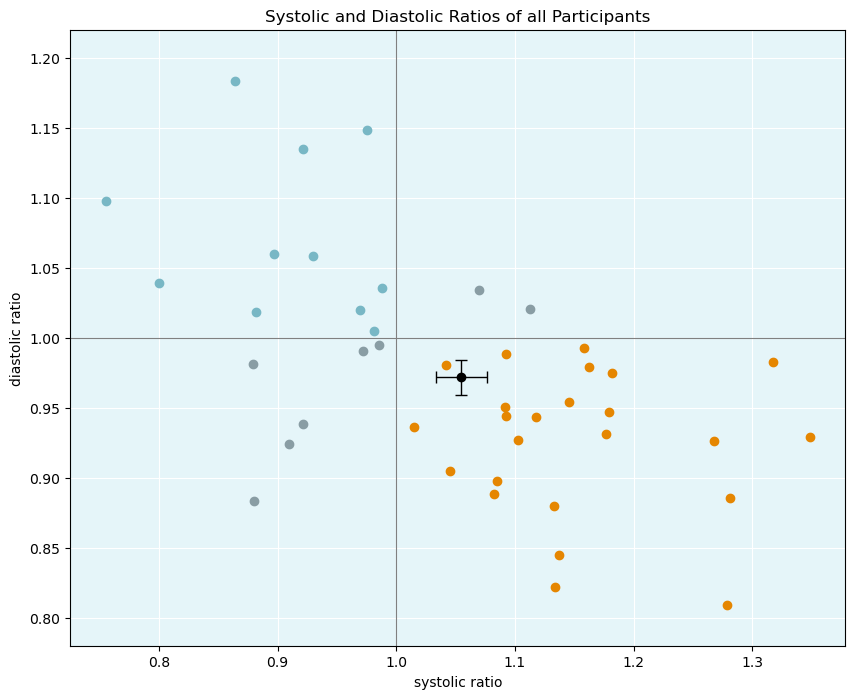

In [320]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.axline((1, 0.8), (1, 1.2 ), linewidth = 0.8, color = "gray")
ax.axline((0.8, 1), (1.2, 1), linewidth = 0.8, color = "gray")
ax.scatter(spec_clicks[(small_sys) & (small_dias)].sysrel, spec_clicks[(small_sys) & (small_dias)].diasrel, color="#899DA4")
ax.scatter(spec_clicks[(small_sys) & (big_dias)].sysrel, spec_clicks[(small_sys) & (big_dias)].diasrel, color="#78B7C5")
ax.scatter(spec_clicks[(big_sys) & (small_dias)].sysrel, spec_clicks[(big_sys) & (small_dias)].diasrel, color="#E58601")
ax.scatter(spec_clicks[(big_sys) & (big_dias)].sysrel, spec_clicks[(big_sys) & (big_dias)].diasrel, color="#899DA4")
plt.errorbar( sys_mean, dias_mean, xerr = st.sem(spec_clicks.sysrel), yerr= st.sem(spec_clicks.diasrel),fmt='o', color = "black", elinewidth=1, capsize=4)
plt.xlabel("Systolic ratio")
plt.ylabel("Diastolic ratio")
ax.set_facecolor("#e5f5f9")  
ax.grid(True, color="white") 
ax.set_axisbelow(True) 
plt.title("Systolic and Diastolic Ratios of all Participants") 
plt.savefig("/Users/emiliahildebrandt/BBSIG script and data/code_x/plots/binary scatterplot 4.png", dpi=350) 
plt.show()

### single inc circular plot

insert participant chosen first level analysis circular plot showing all 120 clicks and their density

In [257]:
inc = 25

defining variables adjusted to the chosen inc

In [258]:
inc = f"inc{inc:02}"
sys_start = allclicks[allclicks["inc"] == inc].pep_len.iloc[0] * 2 * pi
sys_end = 2 * pi * rtend[rtend["p"] == inc].sys_dur.iloc[0]
dias_start = sys_end + 0.05 * 2 * pi
dias_end = 2 * pi - (allclicks[allclicks["inc"] == inc].qonR.iloc[0] * 2 * pi)
circ_clicks = allincs[allincs["inc"] == inc].circ.sort_values()
mean = allclicks[allclicks["inc"] == inc].circ_mean.iloc[0]
magn = allclicks[allclicks["inc"] == inc].magnitude.iloc[0]/len(circ_clicks)

finding the circular density using the Von-Mises-Distribution

In [259]:
sin_sum = np.sum(np.sin(circ_clicks))
cos_sum = np.sum(np.cos(circ_clicks))
mu = np.arctan2(sin_sum, cos_sum)

R = np.sqrt(np.square(sin_sum) + np.square(cos_sum)) / len(circ_clicks)
if R < 0.53:
    kappa = 2 * R + R ** 3 + (5 * R ** 5) / 6
elif R < 0.85:
    kappa = -0.4 + 1.39 * R + 0.43 / (1 - R)
else:
    kappa = 1 / (R ** 3 - 4 * R ** 2 + 3 * R)
if kappa < 0:
    kappa = 0
density = st.vonmises.pdf(circ_clicks, kappa = kappa, loc=mu)
r = np.full_like(np.linspace(0, 2*pi, 100), 1 )

plotting the results

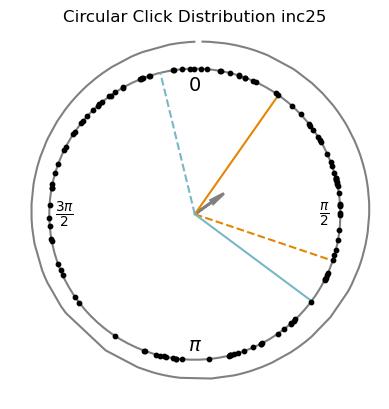

In [324]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(np.linspace(0, 2*pi, 100), r , color = "gray", label = "Density-Minimum")
ax.plot(circ_clicks, density +1, color="gray", label="Von Mises Density")
ax.plot([sys_start,sys_start], [0,1], color = "#E58601", label = "Systole Start" )
ax.plot([sys_end,sys_end], [0,1], color = "#E58601", label = "Systole End", ls = "--")
ax.plot([dias_start,dias_start], [0,1], color = "#78B7C5", label = "Diastole Start" )
ax.plot([dias_end,dias_end], [0,1], color = "#78B7C5", label = "Diastole End", ls = "--" )
ax.scatter(circ_clicks, np.ones(120), s = 10, color = "black", zorder = 2)
ax.arrow(mean, 0, 0, magn, color="gray", head_width=0.2, head_length=0.1, lw=2)
ax.set_theta_direction(-1)  # counterclockwise direction
ax.set_theta_zero_location("N")  # zero angle to north
ax.set_yticklabels([])  # no radial labels
ax.set_yticks([])  # no radial grid lines
ax.set_xticks(np.linspace(0, 2 * pi, 5 ))  
ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", ""], fontsize = 14)  # label ticks
ax.spines["polar"].set_visible(False)
ax.tick_params(axis="x", pad=-50) 
ax.grid(False)
plt.title("Circular Click Distribution " + inc) 
#plt.legend(loc = "upper left")
plt.savefig("/Users/emiliahildebrandt/BBSIG script and data/code_x/plots/circular clicks inc 25.png", dpi=350) 
plt.show()

### circular histogram showing all clicks of all participants over the cardiac cycle

insert number of bins you want for the histogram

In [261]:
bin_num = 30 

defining needed variables

In [262]:
data = spec_incs["circ"]
r_tend_mean = spec_rtend.sys_dur.mean() * 2 * pi
r_tend_std = spec_rtend.sys_dur.std() * 2 * pi
systole = data[data < r_tend_mean]
diastole = data[data > r_tend_mean]
binsize = round(r_tend_mean / (2 * pi) * bin_num)

plotting the histogram

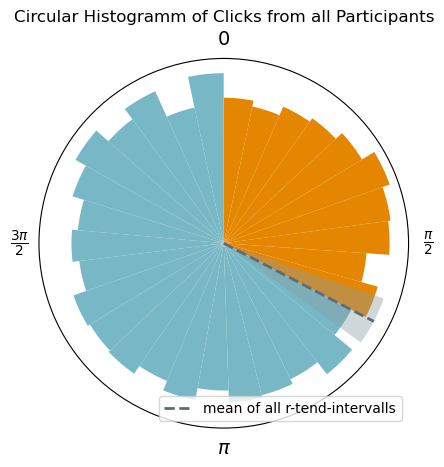

In [331]:
ax = plt.subplot(projection="polar")
ax.hist(systole, bins=binsize, color="#E58601")
ax.hist(diastole, bins=(bin_num - binsize), color="#78B7C5")
ax.set_theta_direction(-1)  # counterclockwise direction
ax.set_theta_zero_location("N")  # zero angle to north
ax.set_yticklabels([])  # no radial labels
ax.set_yticks([])  # no radial grid lines
ax.set_xticks(np.linspace(0, 2 * np.pi, 5))  
ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", ""], fontsize = 14)  # label ticks
ax.plot([r_tend_mean, r_tend_mean], [0, 200], color="#5f6d72", linestyle="--", linewidth=2, label = "mean of all r-tend-intervalls")  # mean of r t end
ax.bar(x = r_tend_mean, height= 200, width = r_tend_std * 2, color = "#899DA4",alpha = 0.4)
ax.set_title("Circular Histogramm of Clicks from all Participants")
ax.grid(False)
plt.legend(loc="lower right")
plt.savefig("/Users/emiliahildebrandt/BBSIG script and data/code_x/plots/circular histo all clicks 4.png", dpi=350) 
plt.show()

### circular plot all incs <br>
plot showing the circular mean of each participant as a dot as well as the overall circular density

defining different parts of the cardiac cycle

In [281]:
circ_means = spec_clicks["circ_mean"]
sys_start_all = spec_clicks["pep_len"].mean() * 2 * pi
sys_end_all = 2 * pi * spec_rtend["sys_dur"].mean()
dias_start_all = sys_end * 0.05 * 2 * pi
dias_end_all = 2*pi - spec_clicks["qonR"].mean() * 2 * pi

calculating the circular density with the von-mises-distribution

In [358]:
circ_means = circ_means.sort_values()
sin_sum_spec = np.sum(np.sin(circ_means))
cos_sum_spec = np.sum(np.cos(circ_means))
mu_spec = np.arctan2(sin_sum, cos_sum)

spec_mean = np.arctan2(sin_sum_spec,cos_sum_spec)
spec_magn = np.sqrt(np.square(sin_sum_spec) + (np.square(cos_sum_spec))) / len(circ_means)

# R = np.sqrt(sin_sum ** 2 + cos_sum**2) / len(circ_means)
# if R < 0.53:
#     kappa = 2 * R + R ** 3 + (5 * R ** 5) / 6
# elif R < 0.85:
#     kappa = -0.4 + 1.39 * R + 0.43 / (1 - R)
# else:
#     kappa = 1 / (R ** 3 - 4 * R ** 2 + 3 * R)
# if kappa < 0:
#     kappa = 0
    
kappa = 1/circ_means.var()

all_density = st.vonmises.pdf(circ_means, kappa = kappa, loc = mu_spec)
r = np.full_like(np.linspace(0, 2*pi, 100), 1 )


plotting clicks and density

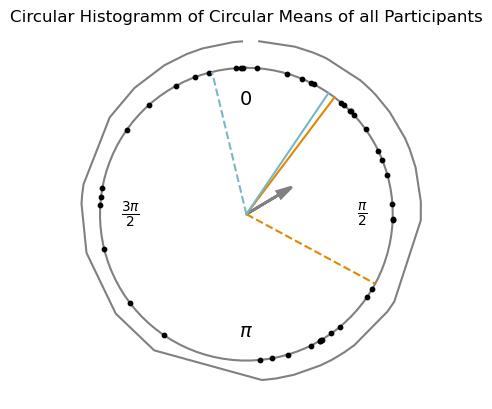

In [359]:
ax = plt.subplot(projection="polar")
ax.plot(np.linspace(0, 2*pi, 100), r , color = "gray", label = "Density-Minimum")
ax.scatter(circ_means, np.ones_like(circ_means), s = 10, color = "black", zorder = 2)
ax.plot(circ_means, all_density +1, color="gray", label="Von Mises Density")
ax.arrow(spec_mean, 0, 0, spec_magn, color="gray", head_width=0.2, head_length=0.1, lw=2)
ax.plot([sys_start_all,sys_start_all], [0,1], color = "#E58601", label = "Systole Start" )
ax.plot([sys_end_all,sys_end_all], [0,1], color = "#E58601", label = "Systole End", ls = "--")
ax.plot([dias_start_all,dias_start_all], [0,1], color = "#78B7C5", label = "Diastole Start" )
ax.plot([dias_end_all,dias_end_all], [0,1], color = "#78B7C5", label = "Diastole End", ls = "--" )
ax.set_theta_direction(-1)  # counterclockwise direction
ax.set_theta_zero_location("N")  # zero angle to north
ax.set_yticklabels([])  # no radial labels
ax.set_yticks([])  # no radial grid lines
ax.set_xticks(np.linspace(0, 2 * np.pi, 5))  
ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", ""], fontsize = 14)  # label ticks
ax.spines['polar'].set_visible(False)
ax.grid(False)
ax.tick_params(axis="x", pad=-60)  
ax.set_title("Circular Histogramm of Circular Means of all Participants")
#plt.legend(loc="lower right")
plt.savefig("/Users/emiliahildebrandt/BBSIG script and data/code_x/plots/circ means 4.png", dpi=350) 
plt.show()
